# Análise dos Diferentes Canais de Comunicação e o Seu Impacto nas Vendas

Este trabalho está a ser realizado no âmbito da Unidade Currricular de Complementos de Estatística para Ciência de Dados.

Identificação do grupo (nº 11): 

* Catarina Juliana Martins Auxiliar	2021134297
  
* Diogo Sousa Machado	2020153309
  
* João Xavier da Silva Leal	2021130506


Com o acompanhameno do professor Francisco José Nibau Antunes.

**Fonte dos dados:** https://www.kaggle.com/datasets/yakhyojon/marketing-promotion/data?select=marketing_sales_data.csv

**Contexto:** O dataset relaciona marketing e vendas, onde diferentes canais de marketing são usados para impulsionar as vendas de um produto ou serviço. Ele pode ser usado para analisar o impacto de investimentos em diversos canais e tipos de influenciadores digitais nas vendas.

**Conteúdo:**
O dataset contém as seguintes colunas:

**`TV`:** Indica o nível de investimento em propagandas televisivas;

**`Radio`:** Representa o gasto em publicidade no rádio (numérica contínua). Valores variam entre 0 e 42;

**`Social Media`:** Indica o investimento em publicidade nas mídias sociais (numérica contínua). Valores variam entre 0 e 11;

**`Influencer`:** Refere-se ao tipo de influenciador contratado para promover os produtos;

**`Sales`:** Representa o total de vendas geradas (variável numérica contínua), que pode ser usada como a variável-alvo (dependente) para modelagem preditiva.

**Objetivo:**

O objetivo deste trabalho é analisar os diferentes canais de comunicação utilizados em campanhas de marketing (TV, Rádio, Mídias Sociais e Influenciadores) e avaliar o impacto desses investimentos nas vendas. Por meio dessa análise, pretende-se identificar quais estratégias de comunicação são mais eficazes e como os recursos podem ser otimizados para maximizar os resultados de vendas.

A troca de dataset nesta fase do trabalho foi motivada pelo facto de no primeiro trabalho ter sido utilizado um dataset com demasiadas variáveis categóricas, deste modo optamos por encontrar um dataset maioritariamente com variáveis numéricas de forma a que a aplicação do algoritmo k-NN seja mais eficiente.

Outro motivo pela escolha deste dataset simples e sem muitos problemas de estrutura foi o facto de nenhum dos elementos do grupo ter experiência prévia na área de análise de dados, pelo que este foi o primeiro projeto realizado e apesar de ter sido testado um dataset mais complexo, optámos por preferir trocar para este mais simples de forma a que fosse mais fácil compreender o trabalho que realizámos.

# Preâmbulo

In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# 1. Importação de dados

In [6]:
df = pd.read_csv("marketing_sales_data.csv")

# 2. Visualização dos dados iniciais e EDA

Nesta etapa vai ser feita uma análise inicial de forma a perceber quais as variáveis em estudo, o tipo de dado que temos e as suas estatísticas de forma a perceber quais serão os passos seguintes. Também serão feitas as correções necessárias para a continuação do estudo.

In [9]:
df

,TV,Radio,Social Media,Influencer,Sales
0,Low,3.518070,2.293790,Micro,55.261284
1,Low,7.756876,2.572287,Mega,67.574904
2,High,20.348988,1.227180,Micro,272.250108
3,Medium,20.108487,2.728374,Mega,195.102176
4,High,31.653200,7.776978,Nano,273.960377
...,...,...,...,...,...
567,Medium,14.656633,3.817980,Micro,191.521266
568,High,28.110171,7.358169,Mega,297.626731
569,Medium,11.401084,5.818697,Nano,145.416851
570,Medium,21.119991,5.703028,Macro,209.326830


In [10]:
df.head()

,TV,Radio,Social Media,Influencer,Sales
0,Low,3.518070,2.293790,Micro,55.261284
1,Low,7.756876,2.572287,Mega,67.574904
2,High,20.348988,1.227180,Micro,272.250108
3,Medium,20.108487,2.728374,Mega,195.102176
4,High,31.653200,7.776978,Nano,273.960377


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TV            572 non-null    object 
 1   Radio         572 non-null    float64
 2   Social Media  572 non-null    float64
 3   Influencer    572 non-null    object 
 4   Sales         572 non-null    float64
dtypes: float64(3), object(2)
memory usage: 22.5+ KB


In [12]:
df.describe()

,Radio,Social Media,Sales
count,572.000000,572.000000,572.000000
mean,17.520616,3.333803,189.296908
std,9.290933,2.238378,89.871581
min,0.109106,0.000031,33.509810
25%,10.699556,1.585549,118.718722
50%,17.149517,3.150111,184.005362
75%,24.606396,4.730408,264.500118
max,42.271579,11.403625,357.788195


In [13]:
(df
 .filter(['TV','Influencer'])
 .astype('object')
 .describe()
 )

,TV,Influencer
count,572,572
unique,3,4
top,Medium,Nano
freq,205,157


In [14]:
df.isnull().sum()

TV              0
Radio           0
Social Media    0
Influencer      0
Sales           0
dtype: int64

**Comentários:**

1. Pela tabela info conseguimos concluir que 3 em 5 variáveis são numéricas, logo vai ser aplicado um método para substituir os valores categóricos por numéricos para as variáveis `TV` e `Influencer`.
2. Na descrição dos dados tanto para a tabela numérica como para a nominal parece existir coerência entre os dados, conseguimos concluir que os registos estão completos (572 para todas as variáveis) e parece existir equilibrio entre a média e o desvio padrão.
3. Não existem valores nulos no dataset, facilitando assim a limpeza.

## 2.1 Correção de formatos e limpeza

**Substituição dos valores categóricos**

A variável **`TV`** está distribuida em 3 categorias: Low, Medium e High. Uma vez que não temos dados para o intervalo de valores entre cada categoria decidimos aplicar um intervalo de valores através da informação que temos relativamente às outras variáveis, no caso vamos utilizar a média das variáveis **`Radio`** e **`Influencer`** como referência. Além disso temos informação sobre a distribuição dos valores nas suas categorias (Low: 201 registos; Medium: 205 registos; High: 166 registos) Sendo assim escolhemos os seguintes valores:

* Low = [1, 6[
* Medium = [7, 13[
* High = [14, 19]

Para a variável **`Influencer`** faremos o mesmo procedimento com a diferença de que as categorias estarem divididas em quatro e temos também a distribuição (Nano: 157 registos; Micro: 151 registos; Mega: 137 registos; Macro: 127 registos), sendo assim, os intervalos são os seguintes:

* Nano = [1,5[
* Micro = [6, 10[
* Mega = [11, 15[
* Macro = [16, 20] 

In [18]:
# distribuição de registos por variável categórica:

categorical_columns = ['TV', 'Influencer']
print("\nValores únicos por variável categórica:")
for col in categorical_columns:
    print(f"\n{col}: {df[col].nunique()} valores únicos")
    print(df[col].value_counts().head())


Valores únicos por variável categórica:

TV: 3 valores únicos
TV
Medium    205
Low       201
High      166
Name: count, dtype: int64

Influencer: 4 valores únicos
Influencer
Nano     157
Micro    151
Mega     137
Macro    127
Name: count, dtype: int64


In [19]:
tv_intervals = {
    "Low": (1, 6),
    "Medium": (7, 13),
    "High": (14, 19)
}

influencer_intervals = {
    'Nano': (1, 5), 
    'Micro': (6, 10), 
    'Mega': (11, 15), 
    'Macro': (16, 21)
}

def generate_random_discrete_values(df, column, intervals):
    generated_values = []
    for category, count in df[column].value_counts().items():
        interval = intervals[category]
        values = np.random.randint(interval[0], interval[1] + 1, size=count)
        generated_values.extend(values)
    np.random.shuffle(generated_values)  # Mistura os valores para evitar padrões
    return generated_values

df['TV_numeric'] = generate_random_discrete_values(df, 'TV', tv_intervals)
df['Influencer_numeric'] = generate_random_discrete_values(df, 'Influencer', influencer_intervals)

In [20]:
df.describe()

,Radio,Social Media,Sales,TV_numeric,Influencer_numeric
count,572.000000,572.000000,572.000000,572.000000,572.000000
mean,17.520616,3.333803,189.296908,9.699301,10.155594
std,9.290933,2.238378,89.871581,5.532309,6.010958
min,0.109106,0.000031,33.509810,1.000000,1.000000
25%,10.699556,1.585549,118.718722,5.000000,5.000000
50%,17.149517,3.150111,184.005362,10.000000,10.000000
75%,24.606396,4.730408,264.500118,15.000000,15.000000
max,42.271579,11.403625,357.788195,19.000000,21.000000


In [21]:
print(df.dtypes)

TV                     object
Radio                 float64
Social Media          float64
Influencer             object
Sales                 float64
TV_numeric              int32
Influencer_numeric      int32
dtype: object


## TAREFA 1 - Seleção Manual de Variáveis

O objetivo deste passo é escolher as variáveis mais relevantes para a análise, evitando incluir variáveis redundantes, irrelevantes ou que possam introduzir ruído, ajudando assim a melhorar a qualidade e a eficiência do modelo. Deste modo, esta tarefa apresenta a visualização da distribuição das variáveis mas também a matriz de correlação entre elas. No final da tarefa estão incluidas as decisões tomadas.

### 1.1 Distribuição de variáveis numéricas


Distribuição das variáveis numéricas:

Análise da variável: Radio
count    572.000000
mean      17.520616
std        9.290933
min        0.109106
25%       10.699556
50%       17.149517
75%       24.606396
max       42.271579
Name: Radio, dtype: float64


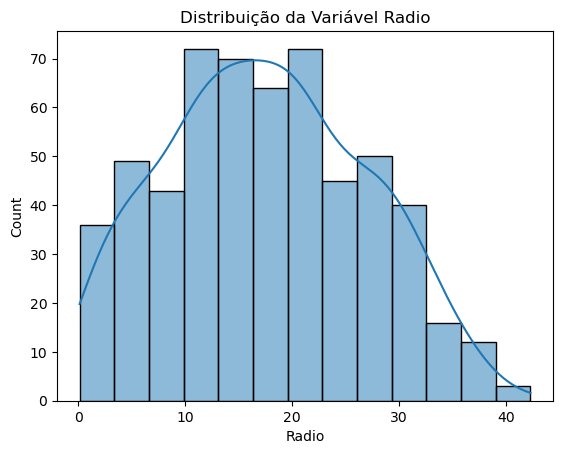


Análise da variável: Social Media
count    572.000000
mean       3.333803
std        2.238378
min        0.000031
25%        1.585549
50%        3.150111
75%        4.730408
max       11.403625
Name: Social Media, dtype: float64


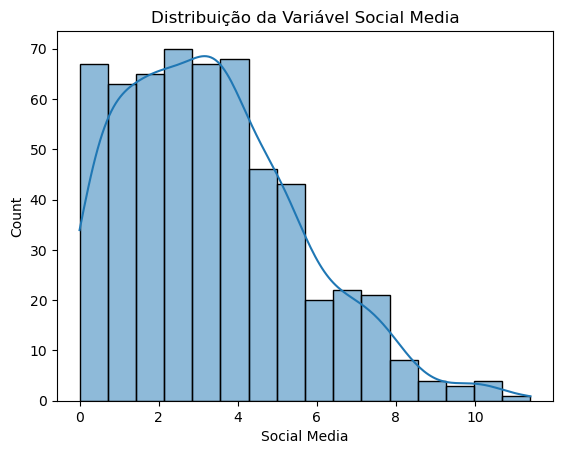


Análise da variável: Sales
count    572.000000
mean     189.296908
std       89.871581
min       33.509810
25%      118.718722
50%      184.005362
75%      264.500118
max      357.788195
Name: Sales, dtype: float64


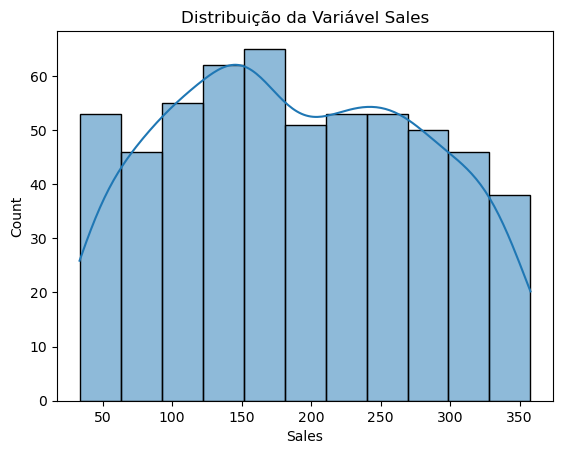


Análise da variável: TV_numeric
count    572.000000
mean       9.699301
std        5.532309
min        1.000000
25%        5.000000
50%       10.000000
75%       15.000000
max       19.000000
Name: TV_numeric, dtype: float64


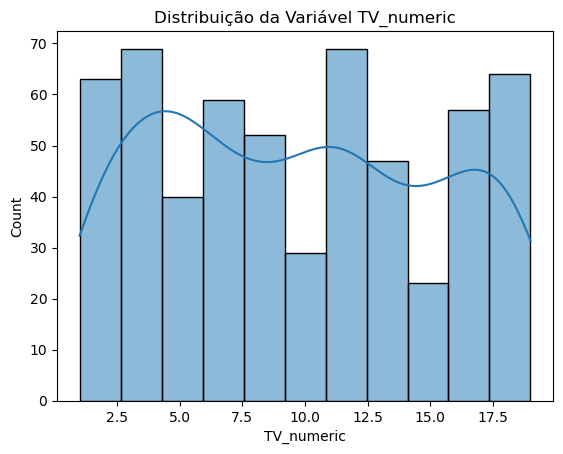


Análise da variável: Influencer_numeric
count    572.000000
mean      10.155594
std        6.010958
min        1.000000
25%        5.000000
50%       10.000000
75%       15.000000
max       21.000000
Name: Influencer_numeric, dtype: float64


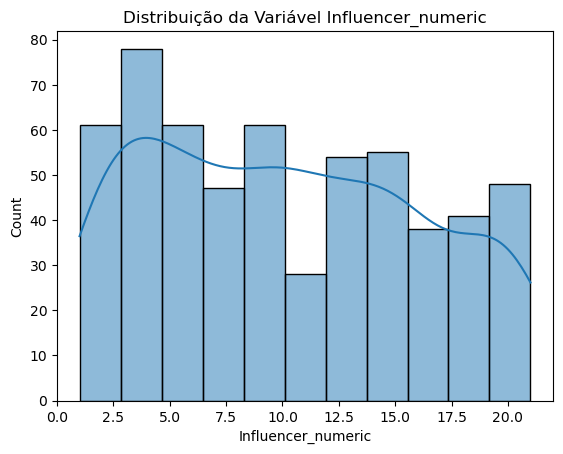

In [25]:
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).columns
print("\nDistribuição das variáveis numéricas:")
for col in numeric_columns:
    print(f"\nAnálise da variável: {col}")
    print(df[col].describe())
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribuição da Variável {col}')
    plt.show()

**Análise:**

* Radio:
  * A distribuição é quase simétrica, mas não perfeitamente normal.
  * O valor médio está em torno de 17.52, com um desvio padrão de 9.29.
  * Os dados estão concentrados no intervalo de 0 a 40, com algumas variações, sem aparentar valores muito discrepantes.
    
* Social Media:
  * Esta variável apresenta uma distribuição assimétrica, com uma cauda longa à direita (right-skewed).
  * A média (3.33) é maior que a mediana (3.15), indicando essa assimetria.
  * A maior parte dos valores está concentrada entre 0 e 6, com alguns valores elevados fora desse intervalo, mas não excessivamente extremos.
    
* Sales:
  * Esta variável revela ter uma distribuição relativamente uniforme ou bimodal, com picos em diferentes regiões.
  * A média (189.30) e a mediana (184.00) estão próximas, o que indica uma distribuição mais equilibrada.
  * O intervalo vai de aproximadamente 30 a 360, mas a concentração principal está entre 100 e 300. 

* TV_numeric:

  * A distribuição é uniforme, com algumas oscilações e picos observados em intervalos específicos.
  * A média está em torno de 9.70, com um desvio padrão de 5.53.
  * Os dados estão concentrados no intervalo de 1 a 19, sem valores extremamente discrepantes ou fora do esperado.

* Influencer_numeric:
  * Esta variável apresenta uma distribuição levemente assimétrica, com uma concentração maior em intervalos mais baixos.
  * A média (10.15) é próxima da mediana (10.00), indicando que a assimetria é mínima.
  * A maior parte dos valores está concentrada entre 5 e 15, com variações moderadas fora desse intervalo, mas sem valores extremamente elevados ou baixos.
    
 
**Conclusões:** 

* Para a imputação k-NN:
  * As variáveis `Radio`, `Sales` e `TV_numeric` apresentam distribuições mais uniformes ou simétricas, o que facilita a imputação de valores omissos, pois o algoritmo k-NN pode operar de maneira eficiente em variáveis contínuas.
  * Para `Social Media` e `Influencer_numeric` a assimetria pode introduzir alguma dificuldade na imputação, especialmente em valores mais extremos.
 
* Valores discrepantes:
  * Nenhuma das variáveis apresenta valores discrepantes que possam influenciar negativamente a imputação ou a análise.

### 1.2 Matriz de correlação das variáveis numéricas


Matriz de Correlação:
                       Radio  Social Media     Sales  TV_numeric  \
Radio               1.000000      0.629941  0.858036   -0.106526   
Social Media        0.629941      1.000000  0.542048   -0.037818   
Sales               0.858036      0.542048  1.000000   -0.120213   
TV_numeric         -0.106526     -0.037818 -0.120213    1.000000   
Influencer_numeric  0.070587      0.014692  0.063225   -0.037193   

                    Influencer_numeric  
Radio                         0.070587  
Social Media                  0.014692  
Sales                         0.063225  
TV_numeric                   -0.037193  
Influencer_numeric            1.000000  


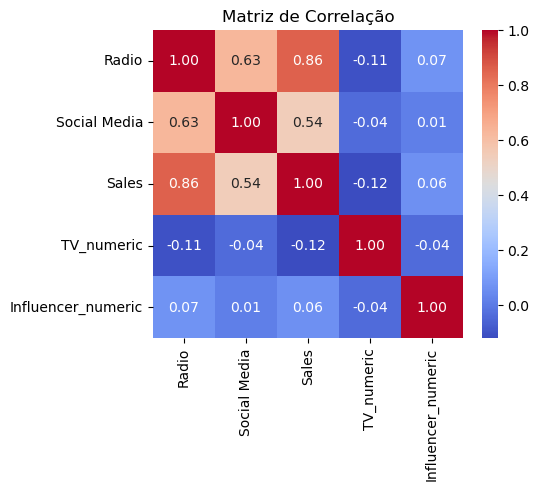

In [28]:
correlation_matrix = df[numeric_columns].corr()
print("\nMatriz de Correlação:")
print(correlation_matrix)
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

**Análise**

* Correlação entre `Radio` e `Sales` (0.86):
  * Existe uma forte correlação positiva entre essas variáveis. Isso significa que, à medida que os valores da variável `Radio` aumentam, os valores de `Sales` tendem a aumentar de forma consistente.
  * Esta relação forte pode ser útil na imputação de valores omissos em qualquer uma das variáveis, pois `Radio` pode ser uma boa preditora para `Sales` e vice-versa.
 
* Correlação entre `Social Media` e `Sales` (0.54):
  * Há uma correlação moderada entre `Social Media` e `Sales.` Embora a relação não seja tão forte quanto a de `Radio` e `Sales,` ainda é significativa.
  * `Social Media` pode contribuir na imputação para `Sales,` mas com menor precisão comparada à variável `Radio.`
 
* Correlação entre `Radio` e `Social Media` (0.63):
  * Existe uma correlação moderada positiva entre essas variáveis. Isso indica que um aumento na variável `Radio` pode estar associado a um aumento em `Social Media,` embora essa relação seja mais fraca do que com `Sales.`
  * Essa relação pode ser explorada dependendo do contexto, mas não é tão preditiva quanto a relação entre `Radio` e `Sales.`

* Correlação das variáveis `TV_numeric` e `Influencer_numeric` entre elas e com as restantes variáveis é negativa. Uma vez que os valores das variáveis foram introduzidos de forma artificial, a aleatoriedade dos mesmos pode ter gerado falta de correlação com as restantes variáveis.
 
**Conclusões:**
* Para imputação com k-NN:
  * A variável `Radio` é altamente correlacionada com `Sales` e apresenta o maior potencial para ser utilizada como preditora na imputação de valores omissos.
  * `Social Media,` embora tenha uma correlação moderada com `Sales` e `Radio,` deve ser utilizada como uma variável complementar na imputação, já que sua relação não é tão forte.
  * As variáveis `TV_numeric` e `Influencer_numeric` devem ser retiradas do estudo de forma a evitar problemas com as restantes variáveis

* Relações fortes e redundância:
  * A alta correlação entre `Radio` e `Sales` pode indicar redundância, dependendo do contexto do problema. Contudo, para fins de imputação, essa relação é benéfica.

In [30]:
# Existe reundância elevada?

high_corr = np.where((correlation_matrix > 0.9) & (correlation_matrix < 1))
high_corr_pairs = [(numeric_columns[i], numeric_columns[j]) for i, j in zip(*high_corr)]

print("Pares de variáveis com alta correlação:")
print(high_corr_pairs)

Pares de variáveis com alta correlação:
[]


**Comentário:**

Aplicamos este código de forma a perceber se existe uma redundância elevada. Como não existem variáveis com correlação maior que 0.9, então não é necessário remover variáveis por redundância. 

Deste modo, todas as variáveis podem ser mantidas para análise, desde que sejam adequadas para o k-NN.  

### 1.3 Distribuição das variáveis categóricas

In [33]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print("Variáveis categóricas com base no tipo de dado:")
print(categorical_columns)

Variáveis categóricas com base no tipo de dado:
Index(['TV', 'Influencer'], dtype='object')



Valores únicos por variável categórica:

TV: 3 valores únicos
TV
Medium    205
Low       201
High      166
Name: count, dtype: int64

Influencer: 4 valores únicos
Influencer
Nano     157
Micro    151
Mega     137
Macro    127
Name: count, dtype: int64


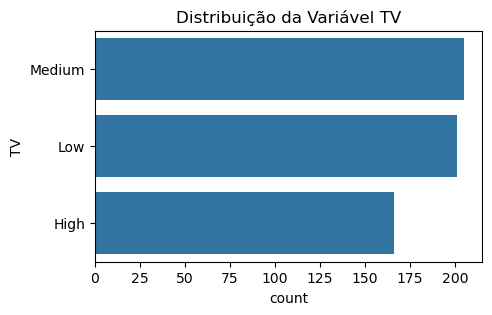

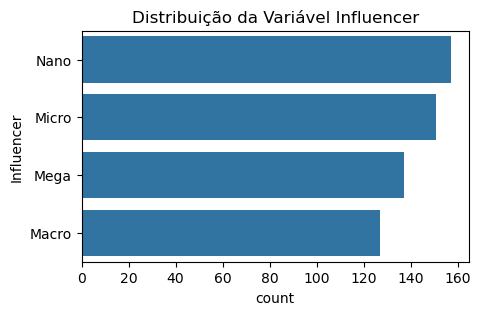

In [34]:
categorical_columns = ['TV', 'Influencer']
print("\nValores únicos por variável categórica:")
for col in categorical_columns:
    print(f"\n{col}: {df[col].nunique()} valores únicos")
    print(df[col].value_counts().head())

# Visualizamos a frequência das categorias para melhor compreender sua distribuição.
for col in categorical_columns:
    plt.figure(figsize=(5, 3))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribuição da Variável {col}')
    plt.show()

**Análise:**

* Distribuição da variável TV:
  * A categoria "Medium" é a mais frequente, seguida da categoria "Low" e depois "High."
  * A distribuição é relativamente equilibrada, mas "Medium" domina ligeiramente a distribuição.
 

* Distribuição da variável Influencer:
  * Nano é a categoria mais frequente (157 ocorrências), seguida por Micro (151 ocorrências).
  * A diferença entre Nano e Macro é de apenas 30 ocorrências, o que indica que a variável está razoavelmente distribuída.
  * A distribuição mostra que os tipos de influencers estão relativamente equilibrados.
 
* Comentário:
  * Ambas as variáveis apresentam distribuições razoáveis, com poucas diferenças entre as categorias. Isto é positivo, pois distribuições muito desequilibradas poderiam afetar a nossa análise.
  * A variável "TV" tem um leve predomínio de categorias médias e baixas, o que pode influenciar análises relacionadas a impacto ou alcance.
  * A variável "Influencer" indica uma tendência de representação maior de influencers menores (Nano e Micro), o que pode ser relevante para estratégias centradas nesse tipo de público.

### 1.4 Seleção das variáveis

In [36]:
df = df.drop(columns=['TV_numeric', 'Influencer_numeric'])

In [37]:
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).columns

In [38]:
variaveis_selecionadas = numeric_columns
print("\nVariáveis selecionadas para imputação:")
print(variaveis_selecionadas)


Variáveis selecionadas para imputação:
Index(['Radio', 'Social Media', 'Sales'], dtype='object')


In [39]:
# Criação de um novo DataFrame com apenas variáveis numéricas
df_selecionado = df[variaveis_selecionadas].copy()
print("\nDataset após seleção de variáveis numéricas:")
print(df_selecionado.head())


Dataset após seleção de variáveis numéricas:
       Radio  Social Media       Sales
0   3.518070      2.293790   55.261284
1   7.756876      2.572287   67.574904
2  20.348988      1.227180  272.250108
3  20.108487      2.728374  195.102176
4  31.653200      7.776978  273.960377


# TAREFA 2 – Sintetização de Valores Omissos e Testagem de Vários Valores de k

A imputação de valores omissos é um processo essencial em análise de dados, pois visa preencher lacunas em conjuntos de dados incompletos, garantindo que as análises subsequentes sejam mais robustas e precisas. Nesta tarefa, foram simulados valores omissos em diferentes variáveis do conjunto de dados original, com percentuais de omissão de 30%. O objetivo é avaliar e comparar métodos de imputação, utilizando métricas como o Mean Squared Error (MSE) e o Mean Absolute Error (MAE), além de ferramentas como o método do cotovelo e a análise de silhueta para determinar o valor ideal de 
𝐾
K no algoritmo k-NN. Este procedimento permite identificar a melhor configuração para minimizar erros e otimizar a qualidade dos dados imputados.

### 2.1 Método de Elbow e Método de Silhueta


Executando K-Means Clustering para análise de agrupamentos...


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

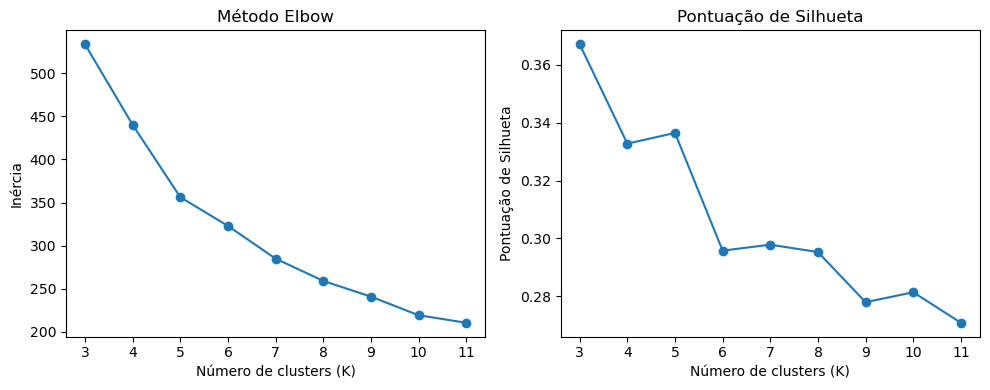

In [45]:
print("\nExecutando K-Means Clustering para análise de agrupamentos...")
inertia = []
silhouette_scores = []

# Normalizar os dados para clustering
scaled_features = (df_selecionado - df_selecionado.mean()) / df_selecionado.std()

for k in range(3, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    
    inertia.append(kmeans.inertia_)
    
    # Calcular Silhouette Score
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(score)

# Plotar o Método Elbow e os Scores de Silhueta
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(3, 12), inertia, marker='o')
plt.title('Método Elbow')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inércia')

plt.subplot(1, 2, 2)
plt.plot(range(3, 12), silhouette_scores, marker='o')
plt.title('Pontuação de Silhueta')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Pontuação de Silhueta')

plt.tight_layout()
plt.show()

**Análise:**

Os gráfico do K-Means Clustering mostram duas métricas importantes para a escolha do número ideal de cluster (K): o Método Elbow e a Pontuação de Silhueta.

* **Gráfico de Método Elbow**:
    * O gráfico apresenta a inércia (soma das distâncias quadradas dentro dos clusters) em função do número de clusters (K).
    * A inércia diminui consistentemente à medida que o número de clusters aumenta. Contudo, o "cotovelo" é identificado de forma mais clara em K=4.
    * Após K=4, a redução na inércia se torna muito menos significativa, indicando que adicionar mais clusters traz benefícios menores.
    * Isso sugere que K=4 é o número de clusters ideal para este conjunto de dados, pois proporciona um bom equilíbrio entre redução da inércia e simplicidade.

---

* **Gráfico de Pontuação de Silhueta**:
    * Este gráfico mede a qualidade dos clusters formados, com valores variando entre -1 e 1. Valores próximos a 1 indicam clusters bem definidos, enquanto valores baixos ou negativos indicam clusters mal definidos ou sobreposição.
    * A pontuação de silhueta é mais alta em K=3 (aproximadamente 0,36), indicando que esse é o número ideal de clusters em termos de separação e coesão.
    * A pontuação de silhueta cai de forma acentuada a partir de K=4, e continua diminuindo com o aumento de clusters, indicando que clusters adicionais se tornam menos significativos ou mais sobrepostos.
    * Para K > 7, os valores de silhueta são consistentemente baixos, reforçando que a coesão dos clusters diminui conforme K aumenta.

### 2.2 Imputação de valores omissos

In [47]:
np.random.seed(42)
missing_rate = 0.3
for col in df_selecionado.columns:
    n_missing = int(missing_rate * len(df_selecionado))
    missing_indices = np.random.choice(df_selecionado.index, n_missing, replace=False)
    df_selecionado.loc[missing_indices, col] = np.nan

print("\nDataset após introdução de valores ausentes:")
print(df_selecionado.isnull().sum())


Dataset após introdução de valores ausentes:
Radio           171
Social Media    171
Sales           171
dtype: int64


### 2.3 Testagem de diferentes valores de K para a imputação

In [ ]:
erros_mse = []
erros_mae = []
valores_k = [2, 3, 4, 6, 8, 10]

df_original_sem_omissos = df[variaveis_selecionadas].dropna()  # Dados originais sem valores ausentes

def preparar_dados_para_comparacao(df_original, df_imputado):
    """Prepara os DataFrames para comparação, garantindo tipos consistentes e alinhamento."""
    df_original = df_original.reset_index(drop=True)
    df_imputado = df_imputado.reset_index(drop=True)
    return df_original, df_imputado

for k in valores_k:
    imputer = KNNImputer(n_neighbors=k)
    df_imputado = pd.DataFrame(imputer.fit_transform(df_selecionado), columns=variaveis_selecionadas)

    # Garantir alinhamento e consistência dos tipos de dados
    df_original, df_imputado = preparar_dados_para_comparacao(df_original_sem_omissos, df_imputado)

    # Comparar com os dados originais (antes de remover os valores)
    mse = mean_squared_error(df_original, df_imputado)
    mae = mean_absolute_error(df_original, df_imputado)
    erros_mse.append(mse)
    erros_mae.append(mae)
    print(f"K={k}: MSE={mse}, MAE={mae}")

**Gráfico de erro de imputação**

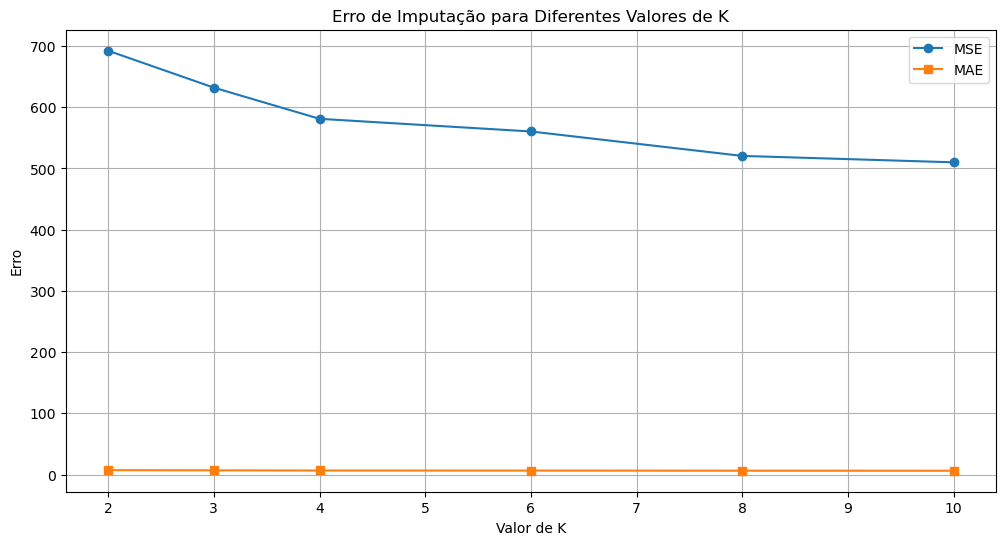

Melhor valor de K (MSE): 10 com MSE=510.06224346063004
Melhor valor de K (MAE): 10 com MAE=6.337889003363291


In [49]:
# Plotar os erros MSE e MAE para diferentes valores de K
plt.figure(figsize=(12, 6))

plt.plot(valores_k, erros_mse, marker='o', label='MSE')
plt.plot(valores_k, erros_mae, marker='s', label='MAE')
plt.xlabel('Valor de K')
plt.ylabel('Erro')
plt.title('Erro de Imputação para Diferentes Valores de K')
plt.legend()
plt.grid()
plt.show()

# Determinar o melhor K com base no menor MSE e MAE
melhor_k_mse = valores_k[np.argmin(erros_mse)]
melhor_k_mae = valores_k[np.argmin(erros_mae)]
print(f"Melhor valor de K (MSE): {melhor_k_mse} com MSE={min(erros_mse)}")
print(f"Melhor valor de K (MAE): {melhor_k_mae} com MAE={min(erros_mae)}")

# Discussão e Conclusão:
# - Use os resultados obtidos para justificar qual valor de K é mais apropriado
# - Comente sobre como os valores ausentes influenciam a imputação
# - Analise como o K escolhido impacta no desempenho geral do algoritmo

**Gráfico k-NN**

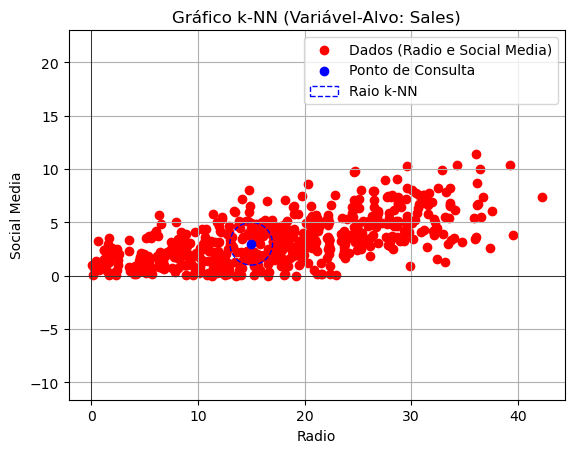

In [115]:

# Usar as variáveis explicativas como grupos (Radio e Social Media)
group_1 = df[['Radio', 'Social Media']].values

# Definir o ponto de consulta (exemplo: valores de Radio e Social Media para prever Sales)
query_point = np.array([15, 3])  # Exemplo: Radio = 15, Social Media = 3

# Plotar os pontos explicativos no plano 2D
plt.scatter(group_1[:, 0], group_1[:, 1], color='red', label='Dados (Radio e Social Media)')

# Plotar o ponto de consulta
plt.scatter(query_point[0], query_point[1], color='blue', label='Ponto de Consulta', zorder=5)

# Desenhar um círculo ao redor do ponto de consulta (para ilustrar \(k\)-NN)
circle = plt.Circle(query_point, radius=2.0, color='blue', fill=False, linestyle='--', label='Raio k-NN')
plt.gca().add_patch(circle)

# Configurar o gráfico
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.xlabel('Radio')
plt.ylabel('Social Media')
plt.title('Gráfico k-NN (Variável-Alvo: Sales)')
plt.axis('equal')
plt.grid(True)

# Exibir o gráfico
plt.show()

**Análise:**

* **Pontos Vermelhos:** Representam observações do dataset, mostrando que à medida que "Radio" aumenta, a variabilidade em "Social Media" também cresce.

* **Ponto Azul:** Marca o ponto de consulta, para o qual o k-NN prevê o valor de "Sales" com base nos vizinhos mais próximos.

* **Círculo Tracejado:** Define o raio do k-NN, contendo os vizinhos usados para calcular a previsão.

* **Densidade dos Dados:** A maior concentração está entre 10-25 em "Radio" e 2-6 em "Social Media", indicando regiões comuns do dataset.

* **Ponto de Consulta e Raio:** O ponto está numa área densa e o raio é bem ajustado, garantindo previsões baseadas em vizinhos relevantes e próximos.

# TAREFA 3 – Avaliação do Desempenho e Discussão/Conclusão

O gráfico de erro de imputação apresenta duas métricas de erro em função dos diferentes valores de : o MSE (Mean Squared Error) e o MAE (Mean Absolute Error).

* Observa-se que o MSE diminui consistentemente conforme K aumenta, indicando que mais vizinhos resultam em melhores estimativas. O menor valor de MSE é atingido em K=10, com um erro de aproximadamente 510, sugerindo que esse é o valor ideal para minimizar o erro quadrático médio.

* MAE:  O MAE permanece constante e muito próximo de 6.34 em todos os valores de K. Isso indica que as diferenças absolutas entre os valores reais e imputados são estáveis, independentemente do número de vizinhos.


Com base nas duas métricas analisadas, o valor ideal de  para a imputação de dados parece ser 10, já que resulta nos menores valores de erro tanto para o MSE quanto para o MAE. Isto sugere que considerar mais vizinhos no processo de imputação resulta em estimativas mais precisas dos valores ausentes.

A análise gráfica do k-NN reforça que K=10 considera um número adequado de vizinhos para a imputação sem adicionar ruídos. Assim, a escolha de K=10 equilibra precisão e robustez, sendo apropriada para os dados analisados.